# t-distributed Stochastic Neighbor Embedding (t-SNE)

--------------------------------------------------------------------------------------------
- _Author_: Abhishek Saurabh
- _Date_ : 28-Dec-2017
- References:
    1. __[Visualizing Data Using t-SNE- Maaten & Hinton (2008)](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)__
    2. __[t-SNE scikit-learn](http://scikit-learn.org/stable/modules/manifold.html#t-sne)__
    3. __[Visualising high-dimensional datasets using PCA and t-SNE in Python](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)__
--------------------------------------------------------------------------------------------

## Introduction
Visualization of high dimensional data is a key to problem solving in multiple domains. As an example, in Bioinformatics, cell nuclei which is relevant to breast cancer, is described by approximately 30 variables. Likewise, image analysis or word embeddings in natural language processing typically have thousands of dimensions. Visualization of such a high dimensional space is an active area of research. 

t-SNE is one of the many machine learning algorithms which was invented for visualization of high dimensional data in a lower dimensional space. As is the goal of similar techniques, the aim is to preserve much of the significant structure of the high dimensional data, as possible in the low dimensional map.  

In this notebook, I have left out the mathematical details of the algorithm. The original paper, link to which is shared in the reference above, is lucid enough to understand it in detail. Nevertheless, I'll explain the idea behind the algorithm.  

## t-SNE
The algorithm comprises of two main steps. First, it defines a probability distribution (usually a normal distribution) in the high dimensional space s.t. the data points which are similar in 'some' respect, have a higher probability of being picked. Second, it defines another probability distribution (`t-distribution`, hence the name) over the data points in the lower dimensional space. It then minimizes the `KL Divergence` between the two distributions w.r.t. to the locations of the points in the map. 

Let's consider $N$ high dimensional points $\mathbf {x} _{1},\dots ,\mathbf {x} _{N}$. t-SNE first computes the conditional probability $p_{j\mid i}$ that point $x_{i}$ would pick $x_{i}$ as its neighbour, if neighbours are picked in proportion to their probability density under a Gaussian centered at $x_{i}$. The conditional probability is given by: 

$\displaystyle p_{j\mid i}={\frac {\exp(-\lVert \mathbf {x} _{i}-\mathbf {x} _{j}\rVert ^{2}/2\sigma _{i}^{2})}{\sum _{k\neq i}\exp(-\lVert \mathbf {x} _{i}-\mathbf {x} _{k}\rVert ^{2}/2\sigma _{i}^{2})}}$

Let $\mathbf {y} _{1},\dots ,\mathbf {y} _{N}$, represent the lower (say _d_) dimensional map of the points. The algorithm tries to learn this mapping in such a way that the resulting distribution in the lower dimensional space reflects the similarities defined by $p_{j\mid i}$ as well. More specifically, $q_{j\mid i}$ is given by the following expression. 

$\displaystyle q_{ij}={\frac {(1+\lVert \mathbf {y} _{i}-\mathbf {y} _{j}\rVert ^{2})^{-1}}{\sum _{k\neq i}(1+\lVert \mathbf {y} _{i}-\mathbf {y} _{k}\rVert ^{2})^{-1}}}$

It must be noted that while a normal distribution is used to model the data points in the original space, a `t-student distribution` is used to map the points in the lower dimensional space. 

The algorithm then determines the location of the points in the map space by minimizing the `KL divergence` between the distribution $P$ and $Q$ using `gradient descent`.  

## Demo
- Dataset: Handwritten digits dataset in `scikit-learn`. 1797 instances with 8\*8(=64) pixels each
- We will use the `scikit-learn` implementation of t-SNE.

In [46]:
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

In [47]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [48]:
# print(digits['DESCR'])

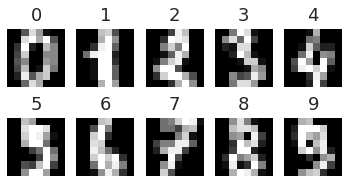

In [49]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])
plt.savefig('images/digits-generated.png', dpi=150)

In [50]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [51]:
digits_proj = TSNE(random_state=RS).fit_transform(X)

In [52]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    return f, ax, sc, txts    

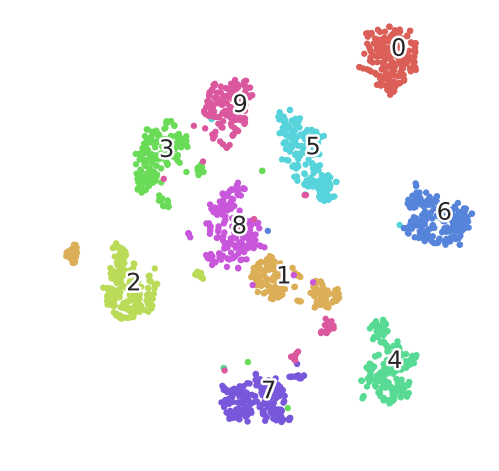

In [53]:
scatter(digits_proj, y)
plt.savefig('images/digits_tsne-generated.png', dpi=120)

## Comparison between PCA and t-SNE

In [54]:
import numpy as np
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
X = mnist.data / 255.0
y = mnist.target

print X.shape, y.shape

(70000, 784) (70000,)


In [55]:
import pandas as pd

feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))

X, y = None, None

print 'Size of the dataframe: {}'.format(df.shape)

Size of the dataframe: (70000, 785)


In [56]:
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
rndperm = np.random.permutation(df.shape[0])

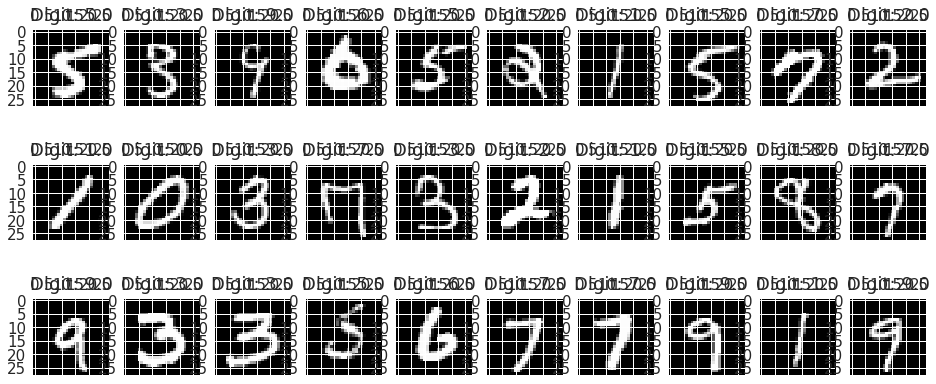

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,30):
    ax = fig.add_subplot(3,10,i+1, title='Digit: ' + str(df.loc[rndperm[i],'label']) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

### PCA 
- Use the first two principal components to plot the lower dimensional space.

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print 'Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)

Explained variation per principal component: [ 0.09746116  0.07155445  0.06149531]


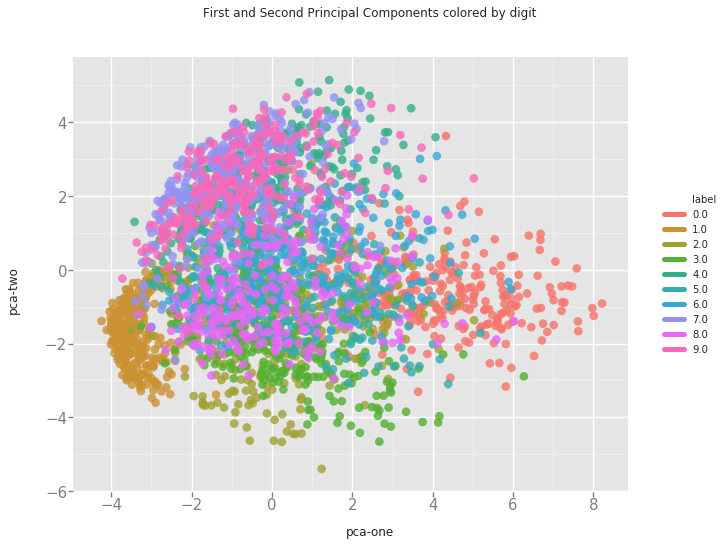

<ggplot: (8787276604493)>

In [60]:
from ggplot import *

chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

### t-SNE
- With 7000 instances of data using all 784 dimensions in MNIST
- Note that the recommended approach to use t-SNE is to use PCA first to reduce the number of dimensions. This is because t-SNE is computationally very expensive. We will follow this recommendation in the following sub-section. 

In [61]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.221s...
[t-SNE] Computed neighbors for 7000 samples in 80.163s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 2.242267
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.098312
[t-SNE] Error after 300 iterations: 2.434924
t-SNE done! Time elapsed: 144.517888069 seconds


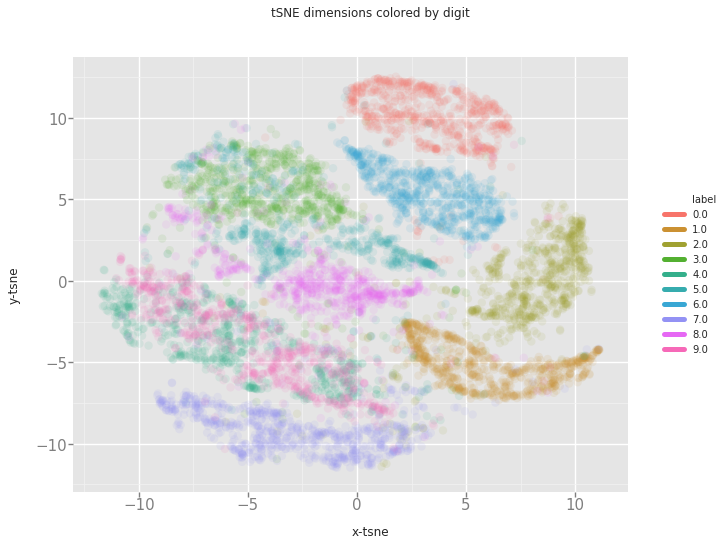

<ggplot: (8787284358157)>

In [62]:
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

### PCA followed by t-SNE
- Use PCA to retain 50 principal components. Then apply t-SNE on the dataset. Use 10,000 instances in this case. 

In [63]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values)

print 'Explained variation per principal component (PCA): {}'.format(np.sum(pca_50.explained_variance_ratio_))

Explained variation per principal component (PCA): 0.82538608882


In [64]:
n_sne = 10000

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50[rndperm[:n_sne]])

print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.103s...
[t-SNE] Computed neighbors for 10000 samples in 15.327s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.859474
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.001747
[t-SNE] Error after 300 iterations: 2.767394
t-SNE done! Time elapsed: 101.80

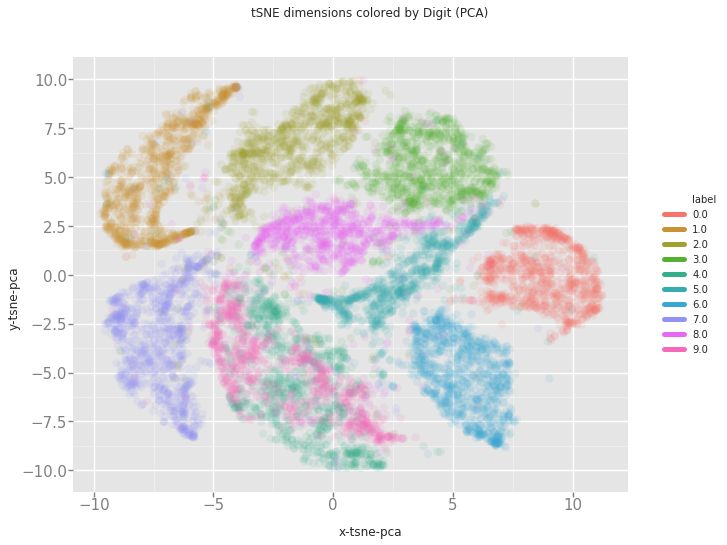

<ggplot: (8787272975605)>

In [65]:
df_tsne = None
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne['y-tsne-pca'] = tsne_pca_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne-pca', y='y-tsne-pca', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by Digit (PCA)")
chart